In [317]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [318]:
def imshow(img):
    img   = img / 2 + 0.5      # un-normalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show

In [219]:
# GPU setup.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [293]:
nBatch = 16
nFinal = 64

In [296]:
transform = transforms.Compose(
    [ transforms.ToTensor()
    , transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset  = torchvision.datasets.CIFAR10(root="./data", train=True,  download=True, transform=transform)
trainload = torch.utils.data.DataLoader(trainset, batch_size=nBatch, shuffle=True,  num_workers=2)

testset   = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testload  = torch.utils.data.DataLoader(testset,  batch_size=nBatch, shuffle=False, num_workers=2)
finalload = torch.utils.data.DataLoader(testset,  batch_size=nFinal, shuffle=False, num_workers=2)

classes   = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 ship   car  ship  frog truck plane  frog  frog  ship   car  deer   dog  bird plane horse plane


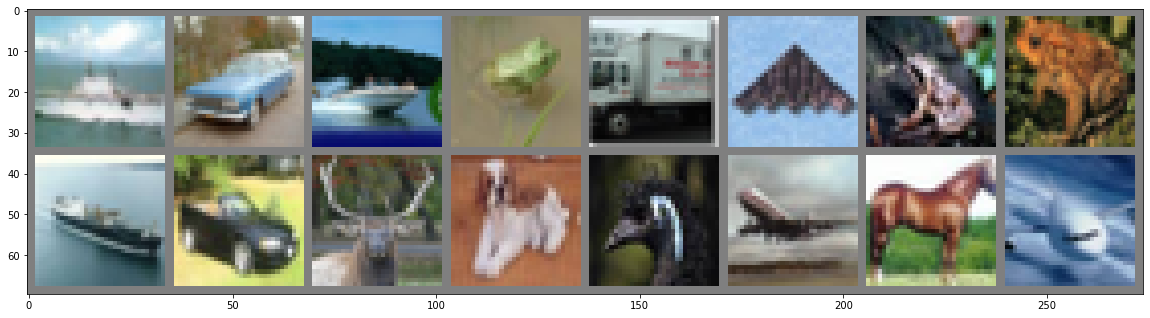

In [247]:
# Print out some sample training images.
dataiter = iter(trainload)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(nBatch)))

In [276]:
def print_accuracy_classes(net):
    class_correct = list(0. for i in range(10))
    class_total   = list(0. for i in range(10))  
    with torch.no_grad():
        for data in testload:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(nBatch):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label]   += 1

    for i in range(10):
        print('   %-5s: %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [277]:
def print_accuracy_total(net):
    total   = 0
    correct = 0
    with torch.no_grad():
        for data in testload:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('  accuracy: %d %%' % (100 * correct / total))

In [278]:
# Define a CNN

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6,  5)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)  
        self.fc3   = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [279]:
net = Net()

# Enable data parallelism on all GPUs,
#  but this will just make it slower for small batch sizes.
# net = nn.DataParallel(net)

net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [280]:
# Define the loss function and optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [282]:
for epoch in range(4):
    print('* Epoch %d' % (epoch + 1))
    
    running_loss = 0.0
    for i, data in enumerate(trainload, 0):
        # get the inputs. data is list of input, label
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 iterations
            print('  loss: %.3f' % (running_loss / 2000))
            running_loss = 0.0

    print_accuracy_total(net)
    print_accuracy_classes(net)
            
print('Finished')

* Epoch 1
  loss: 1.256
  accuracy: 55 %
   plane: 57 %
   car  : 65 %
   bird : 45 %
   cat  : 38 %
   deer : 30 %
   dog  : 43 %
   frog : 81 %
   horse: 66 %
   ship : 65 %
   truck: 64 %
* Epoch 2
  loss: 1.178
  accuracy: 59 %
   plane: 60 %
   car  : 73 %
   bird : 45 %
   cat  : 42 %
   deer : 50 %
   dog  : 52 %
   frog : 67 %
   horse: 61 %
   ship : 73 %
   truck: 69 %
* Epoch 3
  loss: 1.111
  accuracy: 59 %
   plane: 64 %
   car  : 70 %
   bird : 51 %
   cat  : 26 %
   deer : 51 %
   dog  : 54 %
   frog : 72 %
   horse: 62 %
   ship : 76 %
   truck: 64 %
* Epoch 4
  loss: 1.066
  accuracy: 60 %
   plane: 63 %
   car  : 77 %
   bird : 49 %
   cat  : 35 %
   deer : 57 %
   dog  : 56 %
   frog : 64 %
   horse: 54 %
   ship : 79 %
   truck: 66 %
Finished


In [305]:
print_accuracy_classes(net)

   plane: 63 %
   car  : 77 %
   bird : 49 %
   cat  : 35 %
   deer : 57 %
   dog  : 56 %
   frog : 64 %
   horse: 54 %
   ship : 79 %
   truck: 66 %


In [284]:
print_accuracy_total(net)

  accuracy: 60 %


cat    ship   ship   plane  frog   frog   car    frog  
cat    car    plane  truck  dog    horse  truck  ship  
dog    horse  ship   frog   horse  plane  deer   truck 
dog    bird   deer   plane  truck  frog   frog   dog   
deer   dog    truck  bird   deer   car    truck  dog   
deer   frog   dog    frog   plane  truck  cat    truck 
horse  frog   truck  ship   plane  cat    ship   ship  
horse  horse  deer   frog   horse  cat    frog   cat   


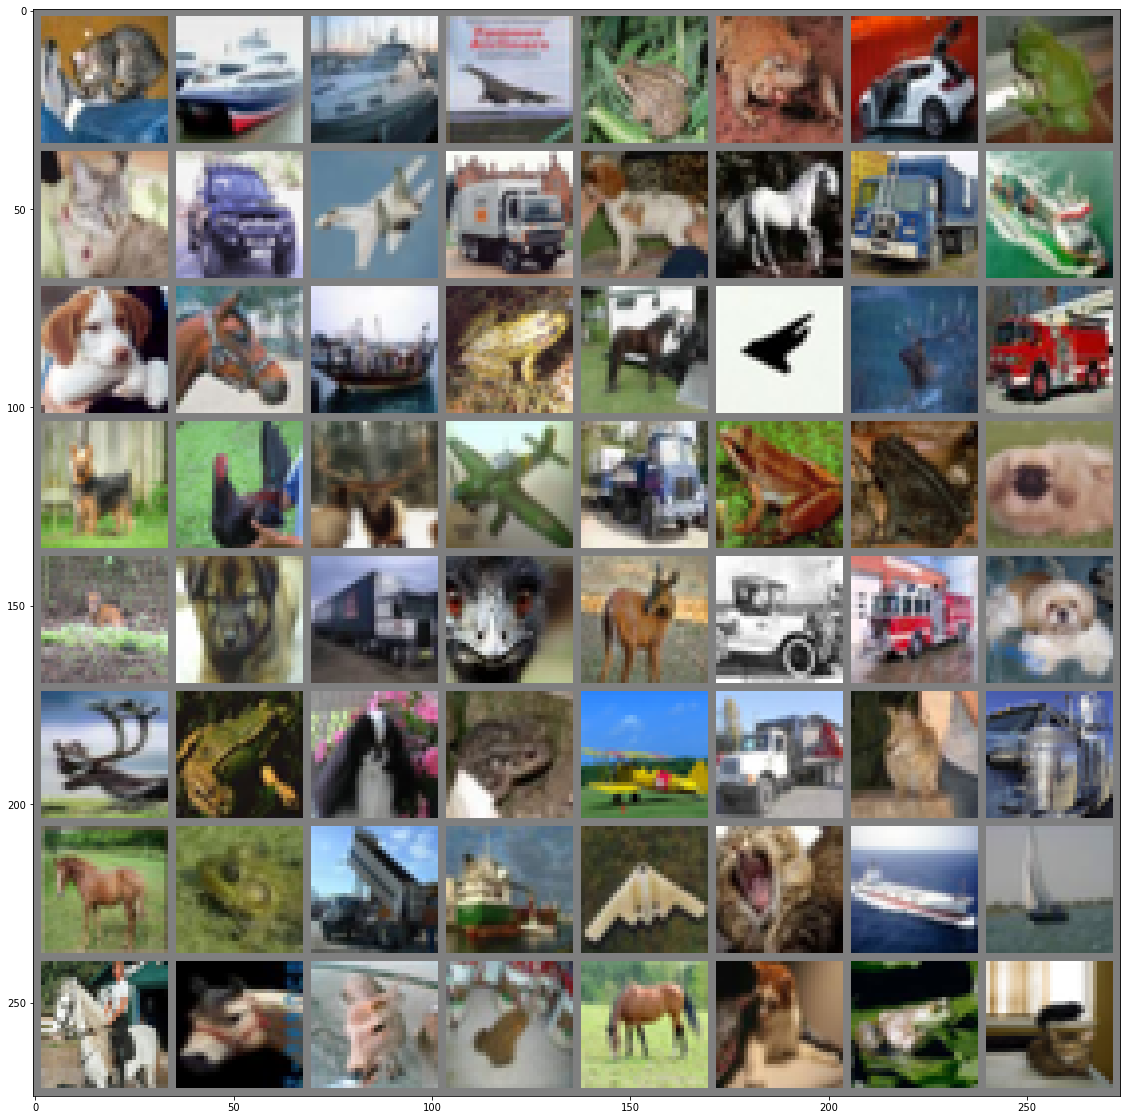

In [309]:
# Test network on test data.
dataiter = iter(finalload)

# for i in range(8):
#    dataiter.next()

images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
for y in range(8):
    print(' '.join('%-6s' % classes[labels[y * 8 + j]] for j in range(8)))

In [316]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

for y in range(8):
    print(' '.join('%-6s' % classes[predicted[y * 8 + j]] for j in range(8)))

print()

for y in range(8):
    print(' '.join('%-6s' % str((labels[y * 8 + j] == predicted[y * 8 + j]).item()) for j in range(8)))

cat    ship   ship   plane  deer   frog   car    deer  
cat    car    plane  truck  dog    horse  truck  ship  
cat    cat    ship   frog   bird   bird   plane  truck 
deer   deer   deer   deer   car    frog   cat    bird  
ship   dog    truck  ship   deer   truck  truck  dog   
plane  frog   dog    frog   plane  truck  cat    truck 
horse  frog   truck  ship   frog   cat    ship   ship  
horse  ship   dog    cat    horse  dog    frog   truck 

True   True   True   True   False  True   True   False 
True   True   True   True   True   True   True   True  
False  False  True   True   False  False  False  True  
False  False  True   False  False  True   False  False 
False  True   True   False  True   False  True   True  
False  True   True   True   True   True   True   True  
True   True   True   True   False  True   True   True  
True   False  False  False  True   False  True   False 


In [261]:
# Save the model.
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)